Data Curation:


Split to Train and Test data

Translation to Protein sequences

Filter anomalous length sequences

Set wild type sequence as the first sequence and align with mmseq2

VAE Model training

Calculate Evolutionary indices

Benign-Pathogenic classification with a two class Gaussian Mixture model

# Visualizatiion

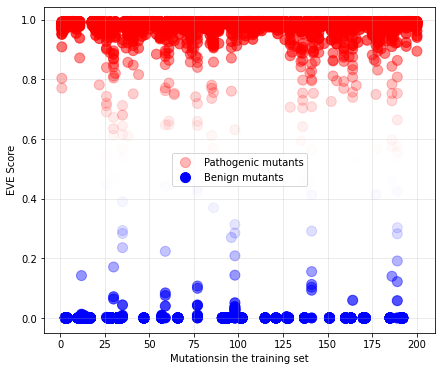

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import matplotlib.cm as cm

def extract_position(mutation):
    match = re.search(r'\d+', mutation)
    if match:
        return int(match.group())
    return None

eve['position'] = eve['mutations'].apply(extract_position)

df_pathogenic = eve[eve['EVE_classes_100_pct_retained'] == 'Pathogenic']
df_benign = eve[eve['EVE_classes_100_pct_retained'] == 'Benign']

alpha_pathogenic = 1 - df_pathogenic['uncertainty']
alpha_benign = 1 - df_benign['uncertainty']

plt.figure(figsize=(7, 6))


plt.scatter(
    df_pathogenic['position'], 
    df_pathogenic['EVE_scores'], 
    c='red', 
    alpha=alpha_pathogenic, 
    label='Pathogenic mutants',
    s=100
)

plt.scatter(
    df_benign['position'], 
    df_benign['EVE_scores'], 
    c='blue', 
    alpha=alpha_benign, 
    label='Benign mutants',
    s=100
)

plt.xlabel('Mutationsin the training set')
plt.ylabel('EVE Score')
plt.grid(True, alpha=0.3)
plt.legend()

# Show the plot
plt.show()

In [ ]:
import pandas as pd
import numpy as np

# --- CONFIG ---
evescape_path = "results_full/summaries/prrsv_scaled_flevo_scores.csv"

# --- Load EVEscape scores ---
evescape_df = pd.read_csv(evescape_path)

# Ensure 'i' (position) is integer for consistent output, though it's likely already.
evescape_df["i"] = evescape_df["i"].astype(int)

# --- Identify Top 1% EVEscape Hotspots ---

# Sort the DataFrame by 'evescape' score in descending order
sorted_evescape_df = evescape_df.sort_values(by="evescape", ascending=True)

# Calculate the number of top entries to select (top 1%)
num_total_mutations = len(sorted_evescape_df)
num_top_1_percent = int(np.ceil(num_total_mutations * 0.01)) # Corrected to 0.01 for 1%

# Ensure at least 1 if there are mutations, and 0 if no mutations
if num_top_1_percent == 0 and num_total_mutations > 0:
    num_top_1_percent = 1
elif num_total_mutations == 0:
    num_top_1_percent = 0

# Select the top N entries
# IMPORTANT: The previous code had a typo here, using num_top_10_percent instead of num_top_1_percent
top_hotspots_df = sorted_evescape_df.head(num_top_1_percent) # Corrected this line!

# --- Prepare the list of hotspot strings (as before) ---
hotspot_list = []
if num_top_1_percent > 0:
    for index, row in top_hotspots_df.iterrows():
        wt_aa = row["wt"]
        position = row["i"]
        mut_aa = row["mut"]

        # Concatenate into a single string: WT_AA + Position + MUT_AA
        hotspot_string = f"{wt_aa}{position}{mut_aa}"
        hotspot_list.append(hotspot_string)

# --- Output the list of hotspot strings ---
print(f"Total unique mutations scored: {num_total_mutations}")
print(f"Number of top 1% hotspots to list: {num_top_1_percent}")
print("\nTop EVEscape Hotspots (WT_AA_Position_MUT_AA):")
comma_separated_hotspots = ", ".join(hotspot_list)
print(comma_separated_hotspots)

# --- NEW: Create and print DataFrame of top 1% residues with their scores ---
print("DataFrame of Top 1% EVEscape Hotspots and their Scores ---")

# Select the relevant columns from top_hotspots_df
# We can also add the combined 'mutation' string for clarity
top_hotspots_with_scores_df = top_hotspots_df[['wt', 'i', 'mut', 'evescape']].copy()
top_hotspots_with_scores_df.rename(columns={'wt': 'WT_AA', 'i': 'Position', 'mut': 'MUT_AA', 'evescape': 'EVEscape_Score'}, inplace=True)

# Add the combined mutation string for easy reference, matching the list output
top_hotspots_with_scores_df['Mutation_String'] = top_hotspots_with_scores_df.apply(
    lambda row: f"{row['WT_AA']}{row['Position']}{row['MUT_AA']}", axis=1
)

# Reorder columns for better readability if desired
top_hotspots_with_scores_df = top_hotspots_with_scores_df[['Mutation_String', 'WT_AA', 'Position', 'MUT_AA','EVEscape_Score']]

top_hotspots_with_scores_df

In [19]:
evescape_df.head()

,i,wt,mut,evol_indices_x,fitness_eve,EVE_scores,EVE_classes_100_pct_retained,uncertainty,dissimilarity_charge_hydro,accessibility_wcn,evescape,mutations,evescape_pos,evescape_sigmoid
0,1,M,A,3.290523,-3.290523,0.987372,Pathogenic,0.097753,-2.143469,-0.526115,-1.919383,M1A,3.904913,0.127930
1,1,M,C,1.755502,-1.755502,0.983898,Pathogenic,0.118957,-1.756578,-0.526115,-1.799103,M1C,4.025193,0.141960
2,1,M,D,1.953304,-1.953304,0.986035,Pathogenic,0.106058,1.435655,-0.526115,-1.623025,M1D,4.201272,0.164788
3,1,M,E,2.253972,-2.253972,0.988026,Pathogenic,0.093611,1.251421,-0.526115,-1.651090,M1E,4.173207,0.160962
4,1,M,F,3.317134,-3.317134,0.987203,Pathogenic,0.098813,-1.517074,-0.526115,-1.880663,M1F,3.943633,0.132313


In [ ]:
from Bio import SeqIO
from Bio.Seq import Seq
import pandas as pd
import math

# --- CONFIG ---
fasta_file = "training_filtered.fasta" # This FASTA file now contains AMINO ACID sequences
evescape_path = "results_full/summaries/prrsv_scaled_flevo_scores.csv"

# --- Wuhan reference Spike AMINO ACID sequence ---
# Replace this with your actual pre-translated Wuhan Spike amino acid sequence
# Make sure it's the full 1273 amino acids if that's your reference length.
wt_seq="MLEKCLTAGYCSQLLFFWCIVPFCFAALVNAASNSSSHLQLIYNLTICELNGTDWLNQKFDWAVETFVIFPVLTHIVSYGALTTSHFLDTAGLITVSTAGYYHGRYVLSSIYAVFALAALICFVIRLTKNCMSWRYSCTRYTNFLLDTKGNLYRWRSPVVIERRGKVEVGDHLIDLKRVVLDGSAATPITKISAEQWGRP"

ref_aa_seq = Seq(wt_seq)

# --- Load EVEscape scores ---
evescape_df = pd.read_csv(evescape_path)
evescape_df["mutations"] = evescape_df["wt"] + evescape_df["i"].astype(str) + evescape_df["mut"]
evescape_df["evescape_pos"] = evescape_df["evescape"] - evescape_df["evescape"].min()
evescape_df["evescape_sigmoid"] = evescape_df["evescape"].apply(lambda x: 1 / (1 + math.exp(-x)))
evescape_dict_pos = dict(zip(evescape_df["mutations"], evescape_df["evescape_pos"]))
evescape_dict_sigmoid = dict(zip(evescape_df["mutations"], evescape_df["evescape_sigmoid"]))

# --- Score sequences by AMINO ACID comparison (no translation needed for input sequences) ---
summary = []
    
for record in SeqIO.parse(fasta_file, "fasta"):
    current_seq_aa = record.seq.upper()  # Ensure uppercase for consistency

    # Trim or pad sequence to match reference length for comparison
    current_seq_aa_to_compare = current_seq_aa[:len(ref_aa_seq)]

    try:
        mutations = []
        for i in range(len(ref_aa_seq)):
            ref_aa = ref_aa_seq[i]
            if i < len(current_seq_aa_to_compare):
                query_aa = current_seq_aa_to_compare[i]
            else:
                continue  # Skip if sequence is shorter than reference

            # Ignore stop, unknown, or gap residues
            if ref_aa in ["*", "X"] or query_aa in ["*", "X", "-"]:
                continue

            if ref_aa != query_aa:
                codon_index = i + 1  # 1-based index
                mut_string = f"{ref_aa}{codon_index}{query_aa}"
                if mut_string in evescape_dict_pos:
                    mutations.append(mut_string)
    except Exception as e:
        print(f"⚠️ Failed to process mutations for {record.id}: {e}")
        continue

    mut_key = ",".join(mutations)
    score_pos = sum(evescape_dict_pos.get(m, 0) for m in mutations)
    score_sigmoid = sum(evescape_dict_sigmoid.get(m, 0) for m in mutations)

    summary.append({
        "sequence_id": record.id,
        "mutation_pattern": mut_key,
        "num_mutations": len(mutations),
        "evescape_score_pos": score_pos,
        "evescape_score_sigmoid": score_sigmoid
    })

# --- Output ---
df_scores = pd.DataFrame(summary)
df_scores.sort_values("evescape_score_pos", ascending=False, inplace=True)

import IPython.display as disp
disp.display(df_scores.head(10))
df_scores.to_csv('results_full/training_scored.csv')

In [ ]:
from Bio import SeqIO
from Bio.Seq import Seq
import pandas as pd
import math

# --- CONFIG ---
fasta_file = "3yr_filtered.fasta" # This FASTA file now contains AMINO ACID sequences
evescape_path = "results_full/summaries/prrsv_scaled_flevo_scores.csv"

# --- Wuhan reference Spike AMINO ACID sequence ---
# Replace this with your actual pre-translated Wuhan Spike amino acid sequence
# Make sure it's the full 1273 amino acids if that's your reference length.
wt_seq="MLEKCLTAGYCSQLLFFWCIVPFCFAALVNAASNSSSHLQLIYNLTICELNGTDWLNQKFDWAVETFVIFPVLTHIVSYGALTTSHFLDTAGLITVSTAGYYHGRYVLSSIYAVFALAALICFVIRLTKNCMSWRYSCTRYTNFLLDTKGNLYRWRSPVVIERRGKVEVGDHLIDLKRVVLDGSAATPITKISAEQWGRP"

ref_aa_seq = Seq(wt_seq)

# --- Load EVEscape scores ---
evescape_df = pd.read_csv(evescape_path)
evescape_df["mutations"] = evescape_df["wt"] + evescape_df["i"].astype(str) + evescape_df["mut"]
evescape_df["evescape_pos"] = evescape_df["evescape"] - evescape_df["evescape"].min()
evescape_df["evescape_sigmoid"] = evescape_df["evescape"].apply(lambda x: 1 / (1 + math.exp(-x)))
evescape_dict_pos = dict(zip(evescape_df["mutations"], evescape_df["evescape_pos"]))
evescape_dict_sigmoid = dict(zip(evescape_df["mutations"], evescape_df["evescape_sigmoid"]))

# --- Score sequences by AMINO ACID comparison (no translation needed for input sequences) ---
summary = []
    
for record in SeqIO.parse(fasta_file, "fasta"):
    current_seq_aa = record.seq.upper()  # Ensure uppercase for consistency

    # Trim or pad sequence to match reference length for comparison
    current_seq_aa_to_compare = current_seq_aa[:len(ref_aa_seq)]

    try:
        mutations = []
        for i in range(len(ref_aa_seq)):
            ref_aa = ref_aa_seq[i]
            if i < len(current_seq_aa_to_compare):
                query_aa = current_seq_aa_to_compare[i]
            else:
                continue  # Skip if sequence is shorter than reference

            # Ignore stop, unknown, or gap residues
            if ref_aa in ["*", "X"] or query_aa in ["*", "X", "-"]:
                continue

            if ref_aa != query_aa:
                codon_index = i + 1  # 1-based index
                mut_string = f"{ref_aa}{codon_index}{query_aa}"
                if mut_string in evescape_dict_pos:
                    mutations.append(mut_string)
    except Exception as e:
        print(f"⚠️ Failed to process mutations for {record.id}: {e}")
        continue

    mut_key = ",".join(mutations)
    score_pos = sum(evescape_dict_pos.get(m, 0) for m in mutations)
    score_sigmoid = sum(evescape_dict_sigmoid.get(m, 0) for m in mutations)

    summary.append({
        "sequence_id": record.id,
        "mutation_pattern": mut_key,
        "num_mutations": len(mutations),
        "evescape_score_pos": score_pos,
        "evescape_score_sigmoid": score_sigmoid
    })

# --- Output ---
df_scores = pd.DataFrame(summary)
df_scores.sort_values("evescape_score_pos", ascending=False, inplace=True)

import IPython.display as disp
disp.display(df_scores.head(10))
df_scores.to_csv('results_full/3yr_scored.csv')

In [ ]:

import pandas as pd

# Load the CSV files
df1 = pd.read_csv("results_full/training_scored.csv")
df2 = pd.read_csv("results_full/3yr_scored.csv")

# Combine the dataframes
df_scores = pd.concat([df1, df2], ignore_index=True)

# Extract date part from sequence_id
df_scores["date_str"] = df_scores["sequence_id"].str.split("|").str[1]

# Convert to datetime object
df_scores["date"] = pd.to_datetime(df_scores["date_str"], errors="coerce")

# Display the entire dataframe with the 'date' column
df_scores.head(100)

In [23]:
df = pd.read_csv("results_full/training_scored.csv")  # Or however you load your data

df['raw_date'] = df['sequence_id'].str.split('|').str[1]

# Keep only rows with date-like strings
date_mask = df['raw_date'].str.match(r"\d{4}-\d{2}-\d{2}")
df = df[date_mask]

# Now safely convert to datetime
df['ds'] = pd.to_datetime(df['raw_date'], format="%Y-%m-%d")


# Convert to datetime format
df['ds'] = pd.to_datetime(df['ds'])


In [24]:
df['y'] = df['evescape_score_sigmoid']
df = df.groupby('ds', as_index=False)['y'].sum()

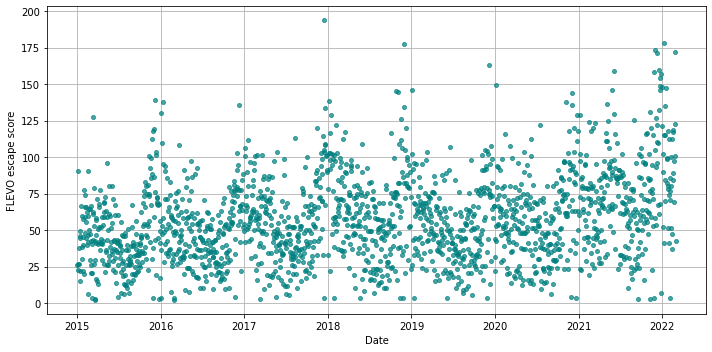

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(df['ds'], df['y'], 'o', markersize=4, color='teal', alpha=0.7)

plt.xlabel('Date')
plt.ylabel('FLEVO escape score')

plt.grid(True)
plt.tight_layout()
plt.show()

10:51:12 - cmdstanpy - INFO - Chain [1] start processing
10:51:12 - cmdstanpy - INFO - Chain [1] done processing


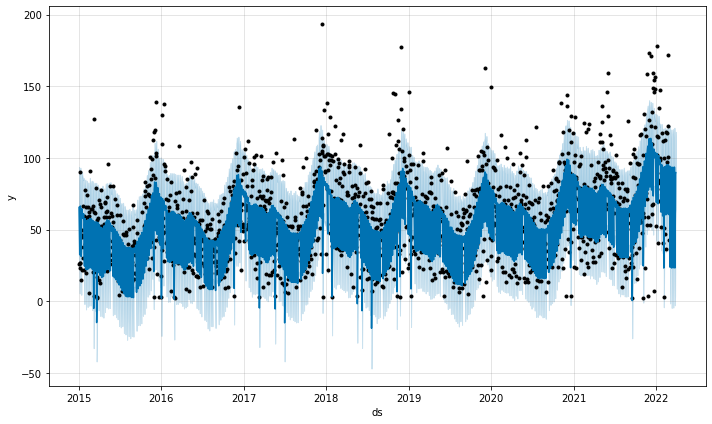

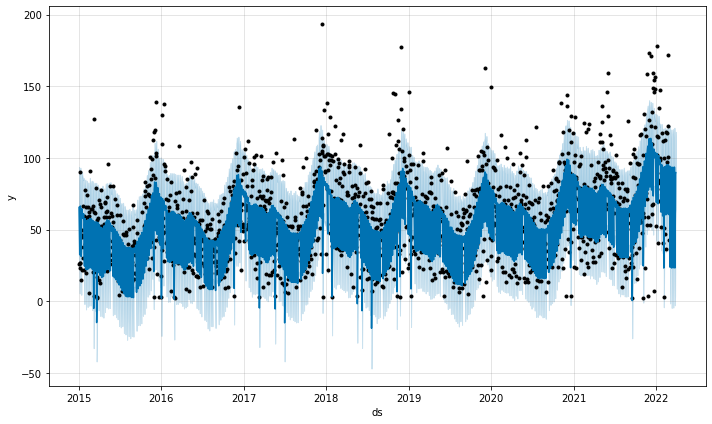

In [26]:
from prophet import Prophet

# Step 1: Instantiate and fit
model = Prophet()
model.fit(df)

# Step 2: Create future dataframe
future = model.make_future_dataframe(periods=30)  # 30 days ahead

# Step 3: Predict
forecast = model.predict(future)

# Step 4: Plot
model.plot(forecast)


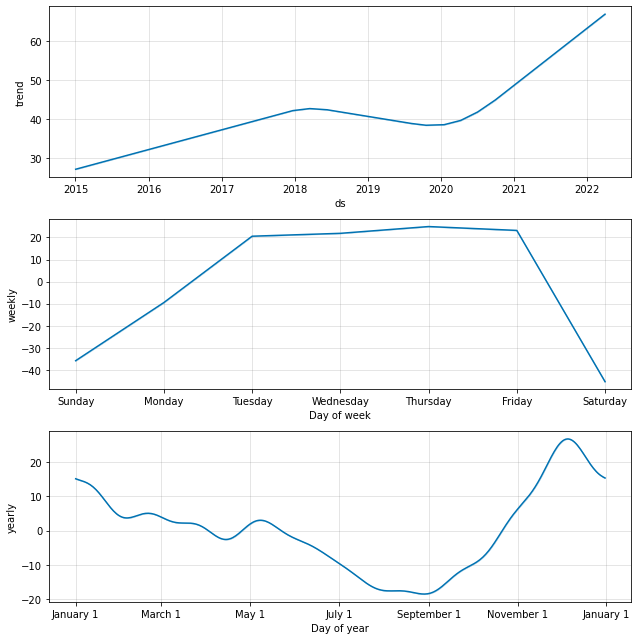

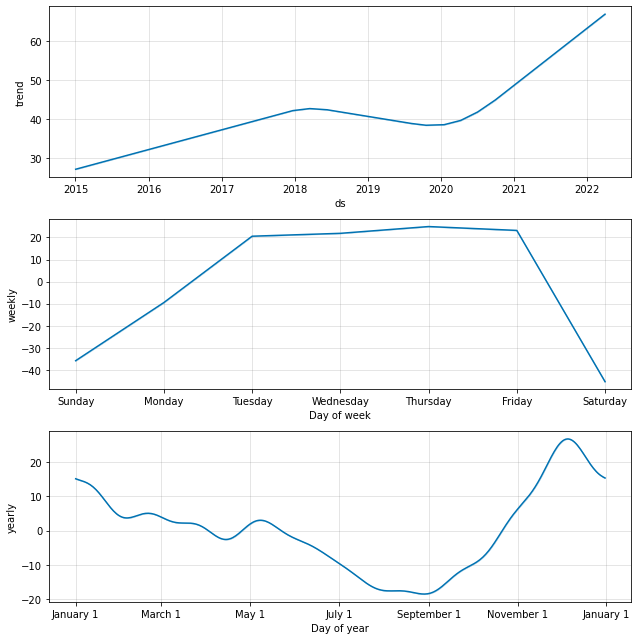

In [27]:
model.plot_components(forecast)

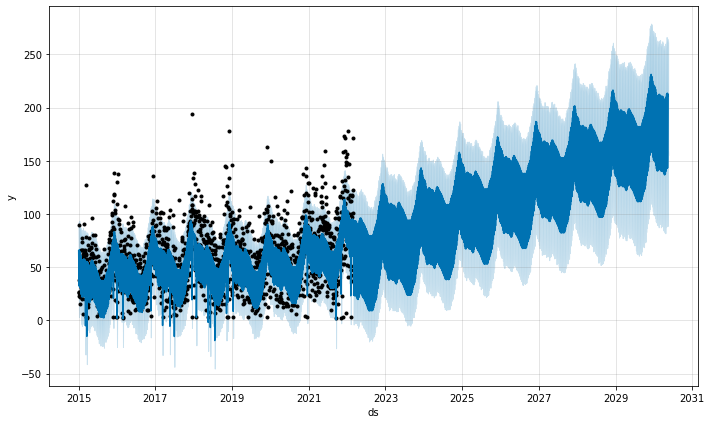

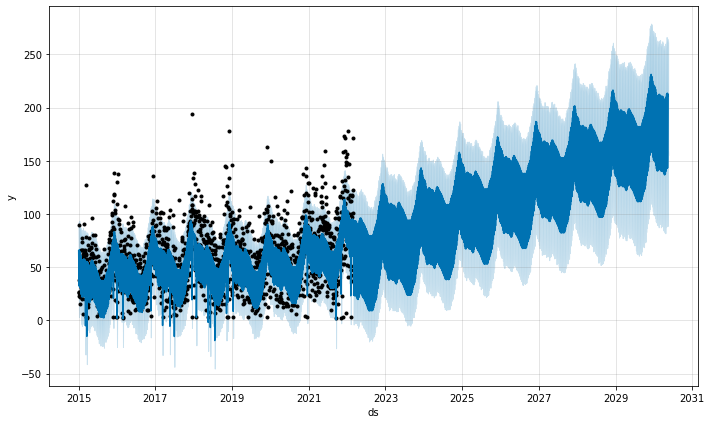

In [28]:
future = model.make_future_dataframe(periods=3000)
forecast = model.predict(future)
model.plot(forecast)


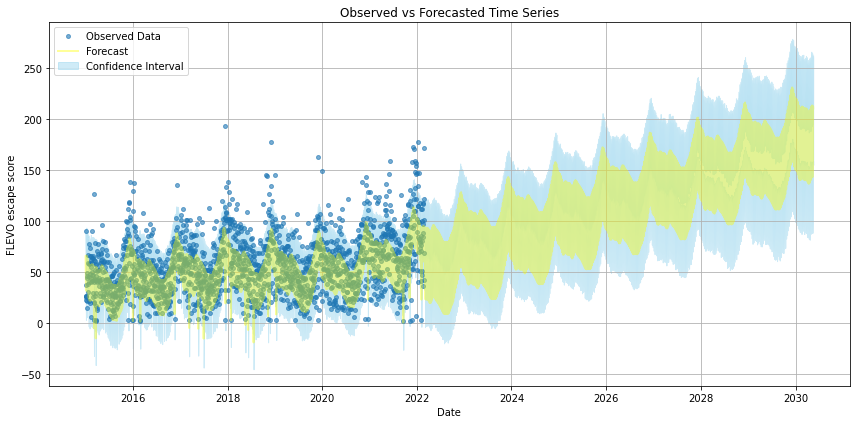

In [32]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 6))

# Plot original data
plt.plot(df['ds'], df['y'], 'o', markersize=4, label='Observed Data', alpha=0.6)

# Plot forecast
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', linewidth=2, color='yellow', alpha=0.4)

# Confidence interval
plt.fill_between(forecast['ds'],
                 forecast['yhat_lower'],
                 forecast['yhat_upper'],
                 color='skyblue',
                 alpha=0.4,
                 label='Confidence Interval')

plt.title('Observed vs Forecasted Time Series')
plt.xlabel('Date')
plt.ylabel('FLEVO escape score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


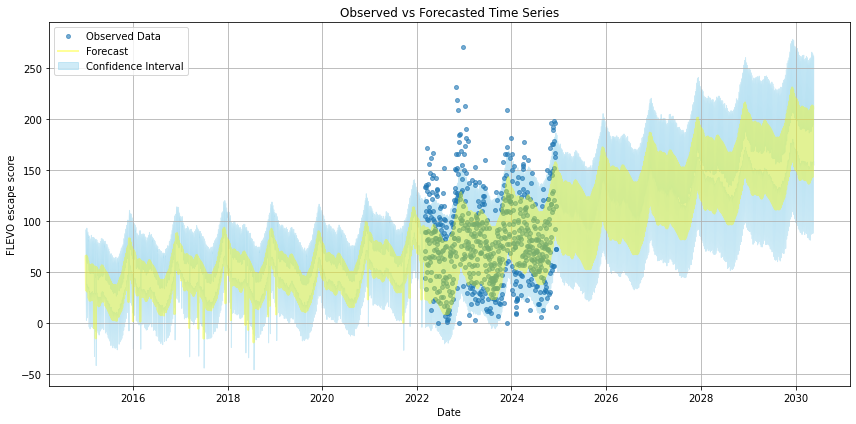

In [37]:
import matplotlib.pyplot as plt
df2= pd.read_csv("results_full/3yr_scored.csv")
df2['raw_date'] = df2['sequence_id'].str.split('|').str[1]

# Keep only rows with date-like strings
date_mask = df2['raw_date'].str.match(r"\d{4}-\d{2}-\d{2}")
df2 = df2[date_mask]

# Now safely convert to datetime
df2['ds'] = pd.to_datetime(df2['raw_date'], format="%Y-%m-%d")


# Convert to datetime format
df2['ds'] = pd.to_datetime(df2['ds'])
df2['y'] = df2['evescape_score_sigmoid']
df2 = df2.groupby('ds', as_index=False)['y'].sum()
plt.figure(figsize=(12, 6))

# Plot original data
plt.plot(df2['ds'], df2['y'], 'o', markersize=4, label='Observed Data', alpha=0.6)

# Plot forecast
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', linewidth=2, color='yellow', alpha=0.4)

# Confidence interval
plt.fill_between(forecast['ds'],
                 forecast['yhat_lower'],
                 forecast['yhat_upper'],
                 color='skyblue',
                 alpha=0.4,
                 label='Confidence Interval')

plt.title('Observed vs Forecasted Time Series')
plt.xlabel('Date')
plt.ylabel('FLEVO escape score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()